Video Link: https://www.youtube.com/watch?v=P5yv8HDFc_M

# Library Setup

In [1]:
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pylab as plt

# Build a model

In [2]:
seq = keras.Sequential(
    [
        keras.Input(
            shape=(None, 40, 40, 1)
        ),  # Variable-length sequence of 40x40x1 frames
        layers.ConvLSTM2D(
            filters=40, kernel_size=(3, 3), padding="same", return_sequences=True
        ),
        layers.BatchNormalization(),
        layers.ConvLSTM2D(
            filters=40, kernel_size=(3, 3), padding="same", return_sequences=True
        ),
        layers.BatchNormalization(),
        layers.ConvLSTM2D(
            filters=40, kernel_size=(3, 3), padding="same", return_sequences=True
        ),
        layers.BatchNormalization(),
        layers.ConvLSTM2D(
            filters=40, kernel_size=(3, 3), padding="same", return_sequences=True
        ),
        layers.BatchNormalization(),
        layers.Conv3D(
            filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
        ),
    ]
)
seq.compile(loss="binary_crossentropy", optimizer="adadelta")

In [3]:
seq.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)        │ (None, None, 40, 40,   │        59,200 │
│                                 │ 40)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, None, 40, 40,   │           160 │
│ (BatchNormalization)            │ 40)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, None, 40, 40,   │       115,360 │
│                                 │ 40)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, None, 40, 40,   │           160 │
│ (BatchNormalization)            │ 40)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_2 (ConvLSTM2D)      │ (None, None, 40, 40,   │       115,360 │
│                                 │ 40)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, None, 40, 40,   │           160 │
│ (BatchNormalization)            │ 40)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_3 (ConvLSTM2D)      │ (None, None, 40, 40,   │       115,360 │
│                                 │ 40)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, None, 40, 40,   │           160 │
│ (BatchNormalization)            │ 40)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d (Conv3D)                 │ (None, None, 40, 40,   │         1,081 │
│                                 │ 1)                     │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 407,001 (1.55 MB)

 Trainable params: 406,681 (1.55 MB)

 Non-trainable params: 320 (1.25 KB)

# Generate artificial data

In [4]:
def generate_movies(n_samples=1200, n_frames=15):
    row = 80
    col = 80
    noisy_movies = np.zeros((n_samples, n_frames, row, col, 1), dtype=np.float64)
    shifted_movies = np.zeros((n_samples, n_frames, row, col, 1), dtype=np.float64)

    for i in range(n_samples):
        # Add 3 to 7 moving squares
        n = np.random.randint(3, 8)

        for j in range(n):
            # Initial position
            xstart = np.random.randint(20, 60)
            ystart = np.random.randint(20, 60)
            # Direction of motion
            directionx = np.random.randint(0, 3) - 1
            directiony = np.random.randint(0, 3) - 1

            # Size of the square
            w = np.random.randint(2, 4)

            for t in range(n_frames):
                x_shift = xstart + directionx * t
                y_shift = ystart + directiony * t
                noisy_movies[
                    i, t, x_shift - w : x_shift + w, y_shift - w : y_shift + w, 0
                ] += 1

                # Make it more robust by adding noise.
                # The idea is that if during inference,
                # the value of the pixel is not exactly one,
                # we need to train the model to be robust and still
                # consider it as a pixel belonging to a square.
                if np.random.randint(0, 2):
                    noise_f = (-1) ** np.random.randint(0, 2)
                    noisy_movies[
                        i,
                        t,
                        x_shift - w - 1 : x_shift + w + 1,
                        y_shift - w - 1 : y_shift + w + 1,
                        0,
                    ] += (noise_f * 0.1)

                # Shift the ground truth by 1
                x_shift = xstart + directionx * (t + 1)
                y_shift = ystart + directiony * (t + 1)
                shifted_movies[
                    i, t, x_shift - w : x_shift + w, y_shift - w : y_shift + w, 0
                ] += 12

    # Cut to a 40x40 window
    noisy_movies = noisy_movies[::, ::, 20:60, 20:60, ::]
    shifted_movies = shifted_movies[::, ::, 20:60, 20:60, ::]
    noisy_movies[noisy_movies >= 1] = 1
    shifted_movies[shifted_movies >= 1] = 1
    return noisy_movies, shifted_movies

Train the model

In [8]:
epochs = 10  # In practice, you would need hundreds of epochs.

noisy_movies, shifted_movies = generate_movies(n_samples=1200)
seq.fit(
    noisy_movies[:1000],
    shifted_movies[:1000],
    batch_size=10,
    epochs=epochs,
    verbose=2,
    validation_split=0.1,
)

Epoch 1/10
90/90 - 32s - 357ms/step - loss: 0.5550 - val_loss: 0.5575
Epoch 2/10
90/90 - 33s - 361ms/step - loss: 0.5410 - val_loss: 0.5402
Epoch 3/10
90/90 - 40s - 449ms/step - loss: 0.5275 - val_loss: 0.5290
Epoch 4/10
90/90 - 32s - 357ms/step - loss: 0.5145 - val_loss: 0.5154
Epoch 5/10
90/90 - 32s - 353ms/step - loss: 0.5019 - val_loss: 0.5030
Epoch 6/10
90/90 - 32s - 353ms/step - loss: 0.4901 - val_loss: 0.4872
Epoch 7/10
90/90 - 32s - 353ms/step - loss: 0.4783 - val_loss: 0.4788
Epoch 8/10
90/90 - 32s - 353ms/step - loss: 0.4672 - val_loss: 0.4647
Epoch 9/10
90/90 - 32s - 352ms/step - loss: 0.4561 - val_loss: 0.4533
Epoch 10/10
90/90 - 32s - 352ms/step - loss: 0.4455 - val_loss: 0.4426


# Test the model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


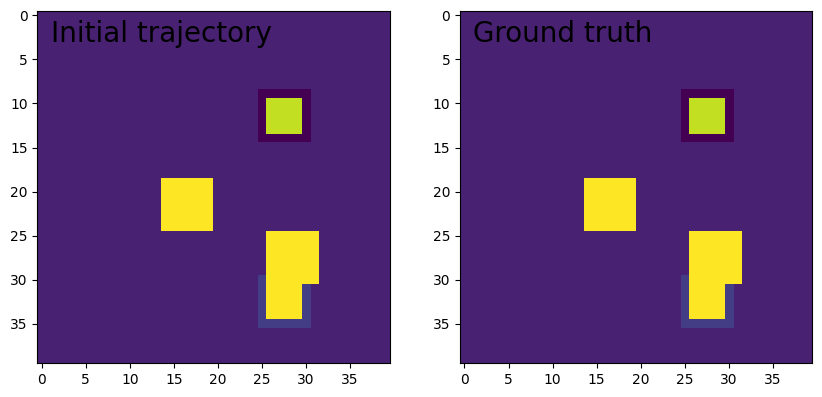

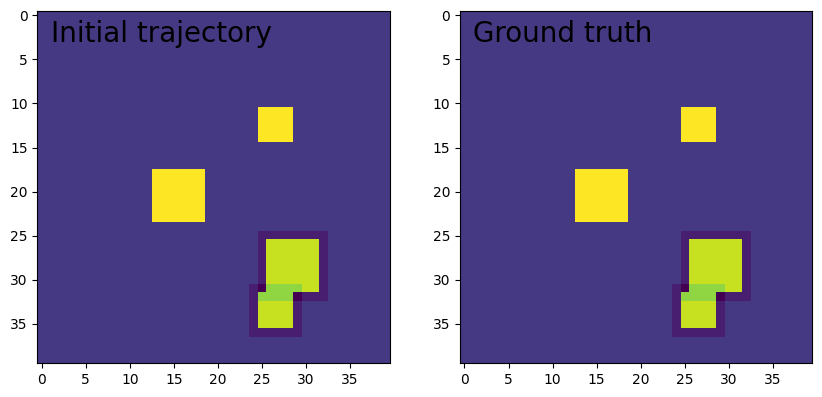

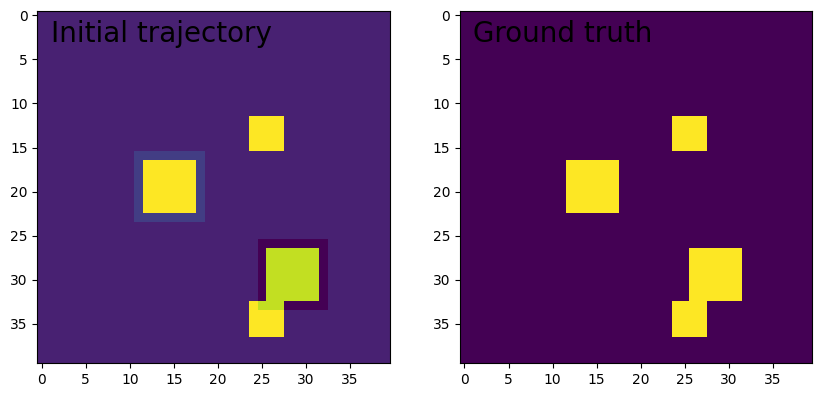

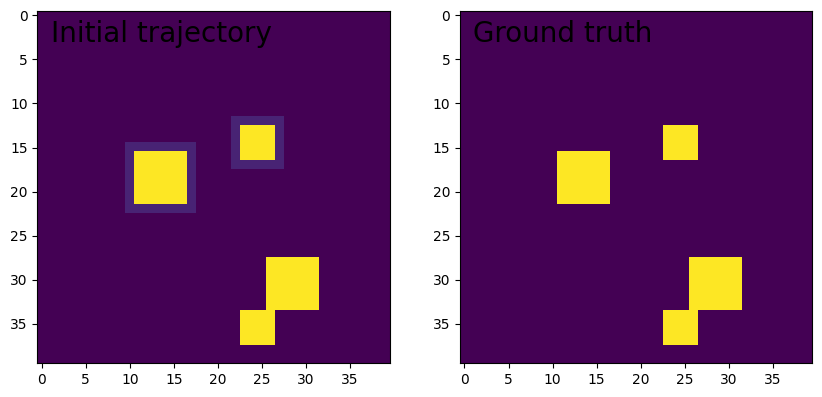

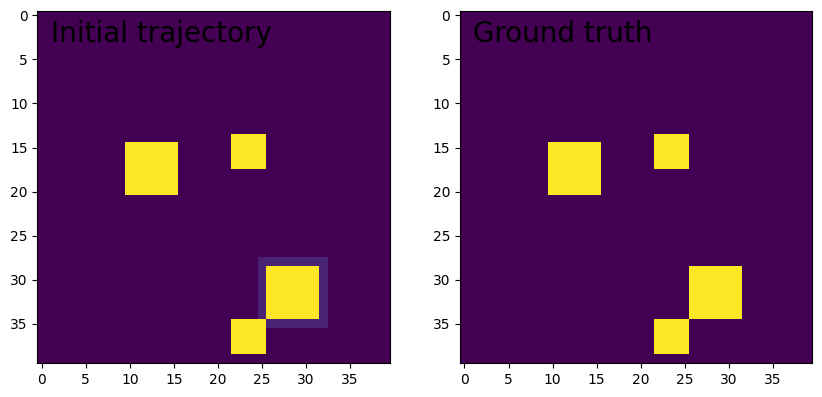

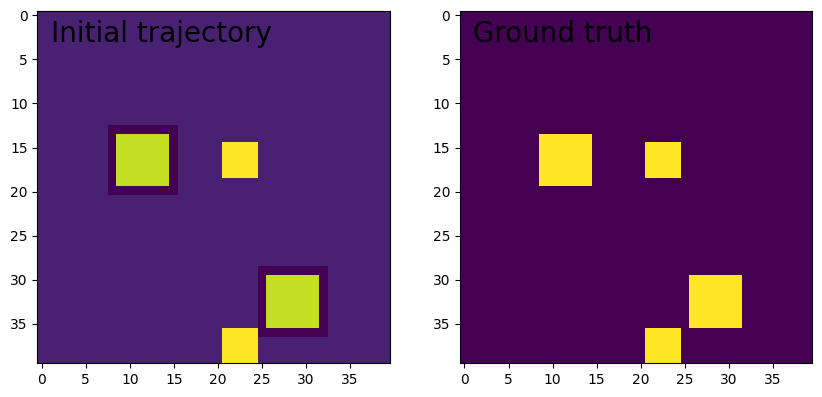

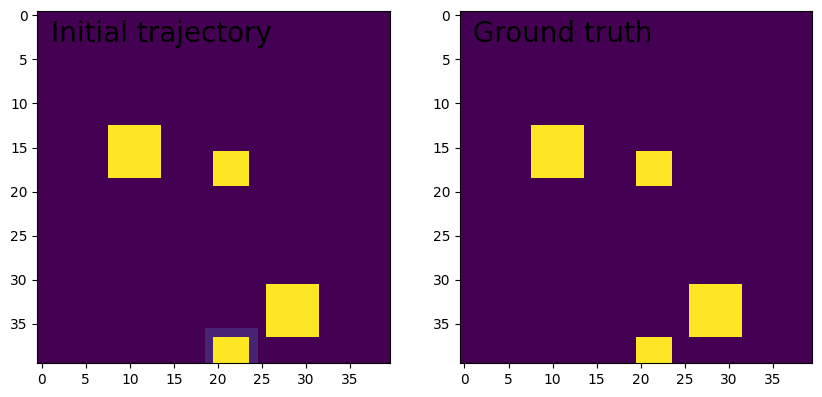

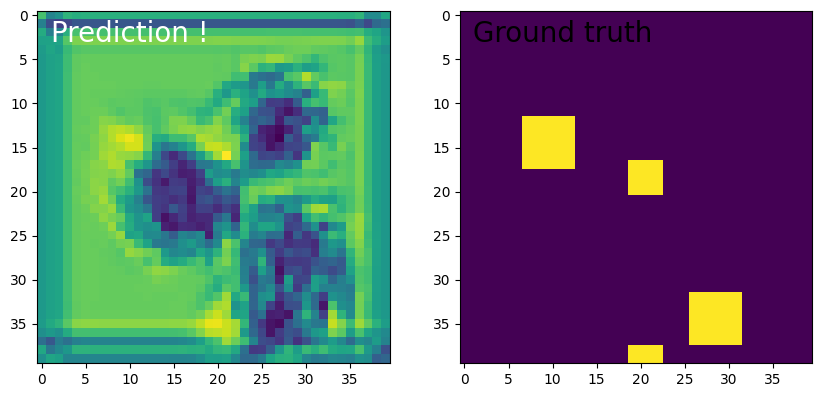

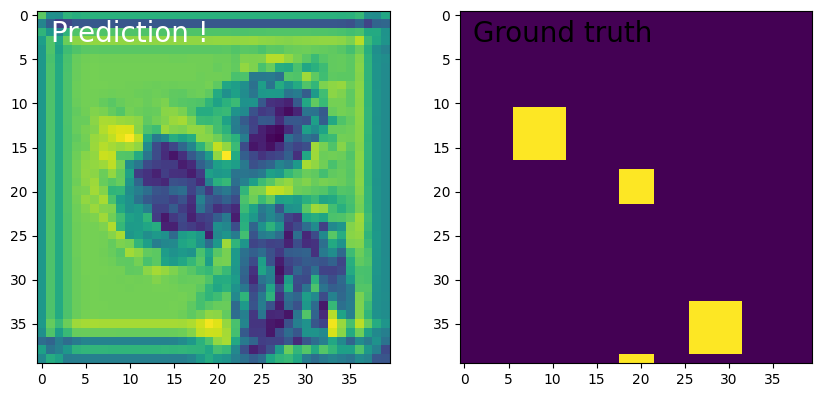

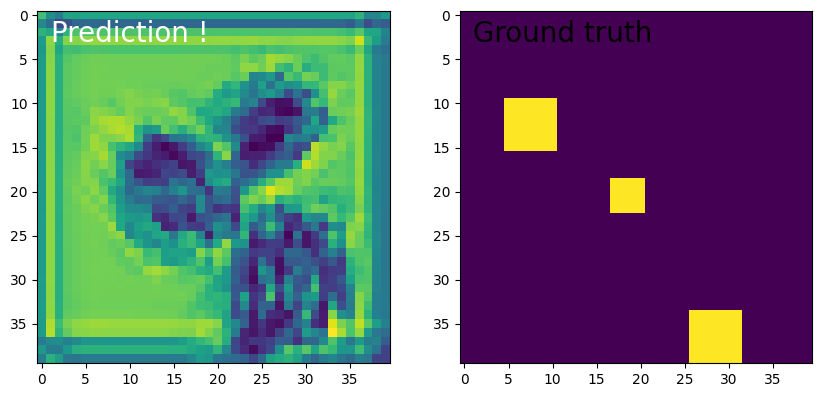

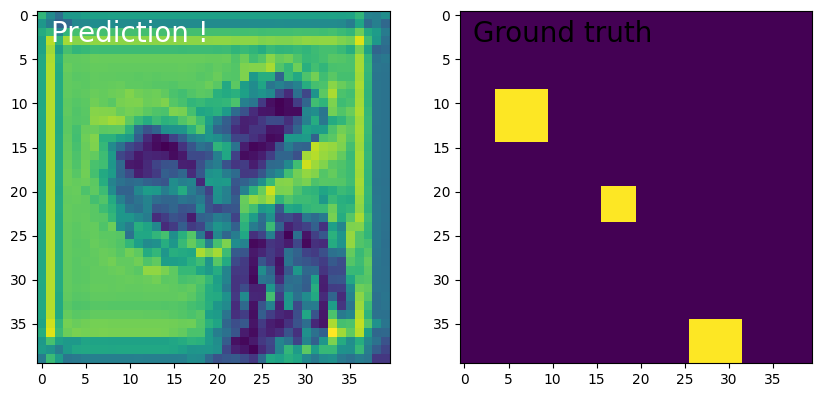

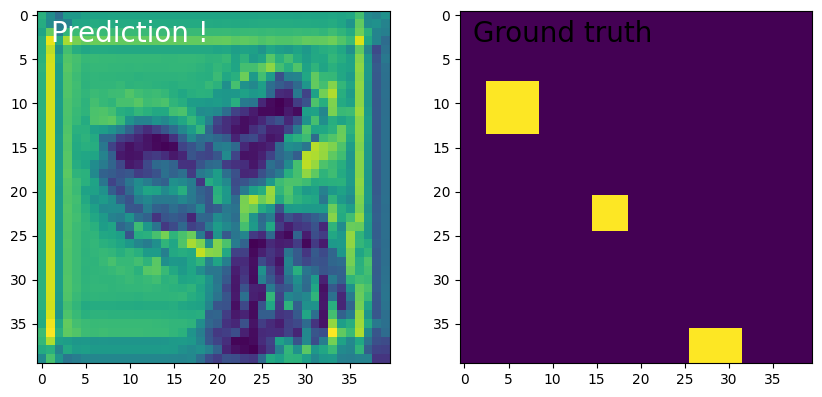

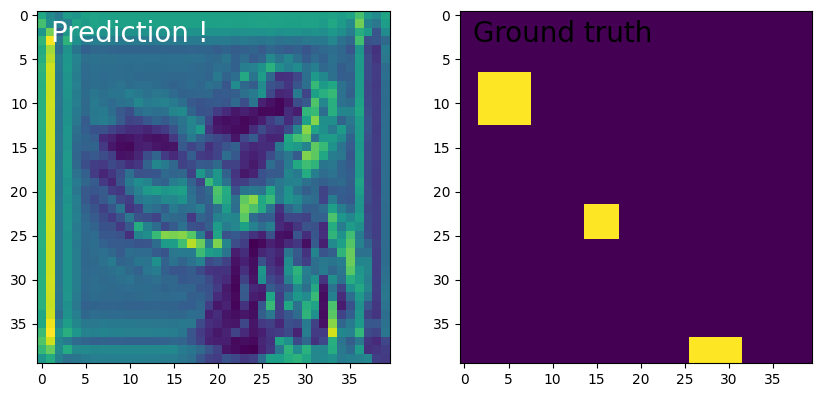

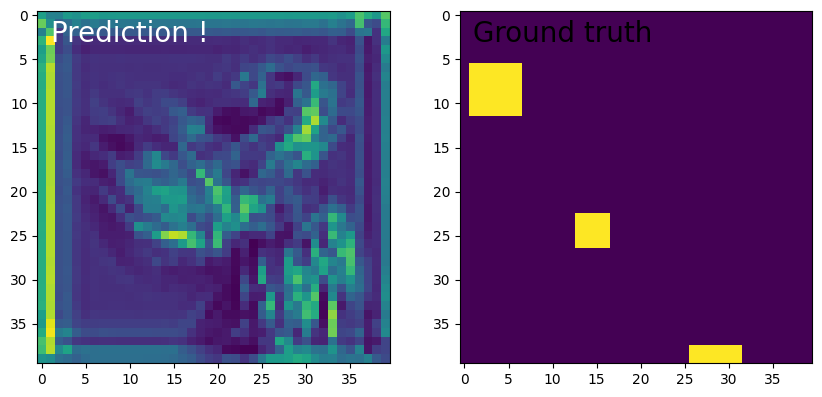

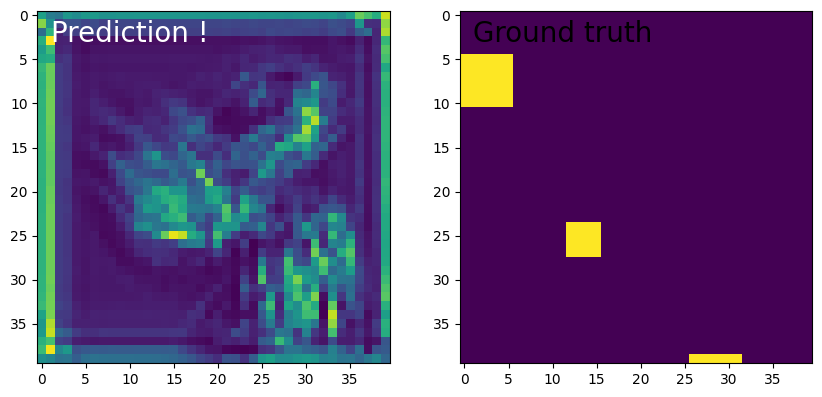

In [11]:
movie_index = 1004
test_movie = noisy_movies[movie_index]

# Start from first 7 frames
track = test_movie[:7, ::, ::, ::]

# Predict 16 frames
for j in range(16):
    new_pos = seq.predict(track[np.newaxis, ::, ::, ::, ::])
    new = new_pos[::, -1, ::, ::, ::]
    track = np.concatenate((track, new), axis=0)

# And then compare the predictions to the ground truth
track2 = noisy_movies[movie_index][::, ::, ::, ::]
for i in range(15):
  fig = plt.figure(figsize=(10, 5))

  ax = fig.add_subplot(121)

  if i >= 7:
    ax.text(1,3, "Prediction !", fontsize=20, color="w")
  else:
    ax.text(1,3, "Initial trajectory", fontsize=20)

  toplot = track[i, ::, ::, 0]

  plt.imshow(toplot)
  ax = fig.add_subplot(122)
  plt.text(1,3, "Ground truth", fontsize=20)

  toplot = track2[i, ::, ::, 0]
  if i >= 2:
    toplot = shifted_movies[movie_index][i - 1, ::, ::, 0]

  plt.imshow(toplot)
  plt.savefig("%i_animate.png" % (i +1))